In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample

import seaborn as sns

import statsmodels.tsa.stattools as tools

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.regression.linear_model import yule_walker

In [21]:
weather_data = pd.read_csv('data\\weather.csv')
weather_data.TAVG = (weather_data.TAVG - 32) * 5/9

# Wykres danych

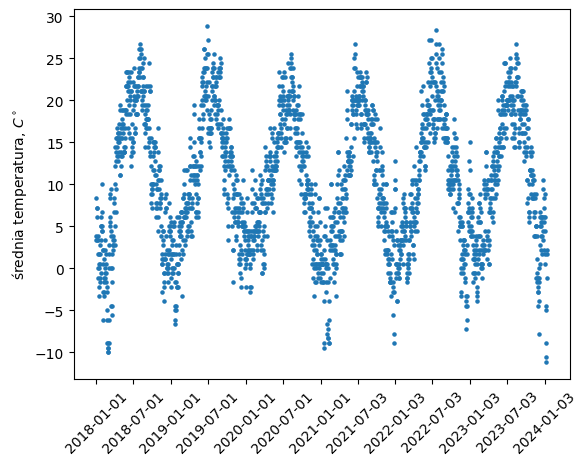

In [22]:
_, ax = plt.subplots()
ax.set_ylabel('średnia temperatura, $C^\circ$')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.tick_params(axis='x', rotation=45)
ax.scatter(weather_data.DATE, weather_data.TAVG, s=5)
plt.savefig('pictures\\wykres_danych.pdf')

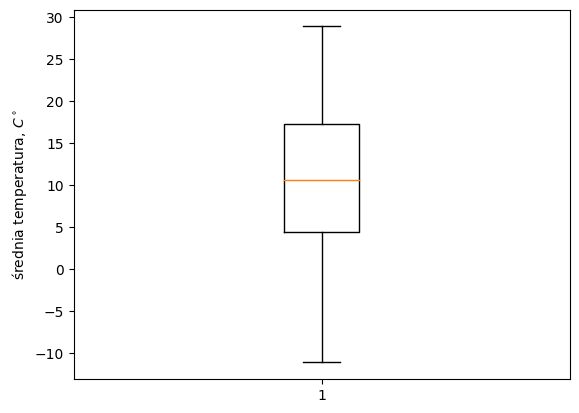

In [23]:
plt.ylabel('średnia temperatura, $C^\circ$')
plt.boxplot(weather_data.TAVG)
plt.savefig('pictures\\boxplot_dane.pdf')

# Dzielenie zbioru danych

Pierwsze 90% - training, ostatnie 10% - testowy.

In [24]:
train_data = weather_data[:int(0.9*len(weather_data))]
test_data = weather_data[int(0.9*len(weather_data)):]

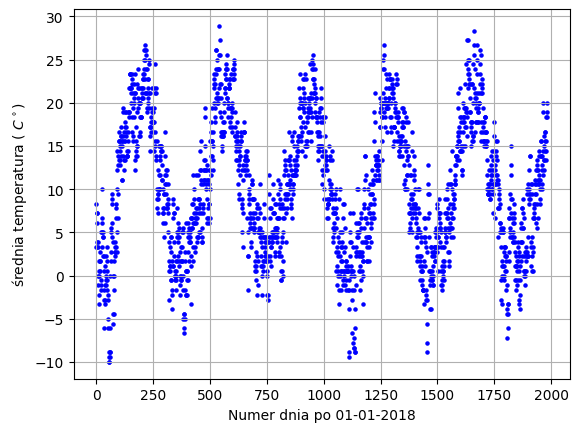

In [25]:
_, ax = plt.subplots()
ax.set_ylabel('średnia temperatura ( $C^\circ$)')
ax.set_xlabel('Numer dnia po 01-01-2018')
ax.scatter(range(len(train_data)), train_data.TAVG, s=5, c="blue")
plt.grid()
plt.savefig('pictures\\wykres_pierwszej_czesci.png')


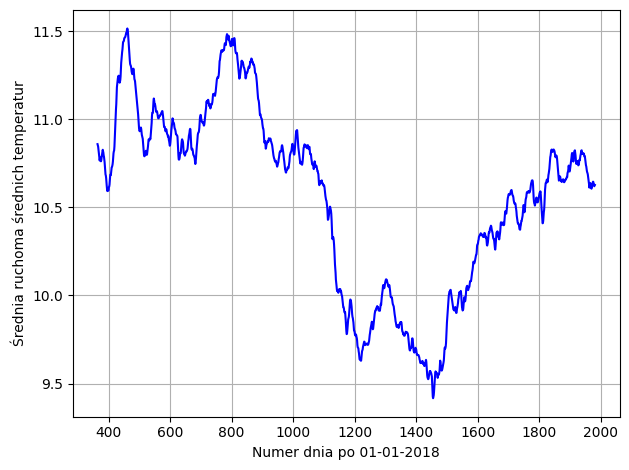

In [26]:
_=train_data.TAVG.rolling(365).mean().plot(c="blue")
plt.grid()
plt.ylabel('Średnia ruchoma średnich temperatur')
plt.xlabel('Numer dnia po 01-01-2018')
plt.tight_layout()
plt.savefig("pictures//sr_trend.png")

Jak widać na powyższym wykresie, w danych nie ma trendu liniwego, natomiast są wahania sezonowe. To oznacza, że średnia temperatura zależy od czasu i nie jest stała, a więc szereg czasowy nie jest stacjonarny w słabym sensie.

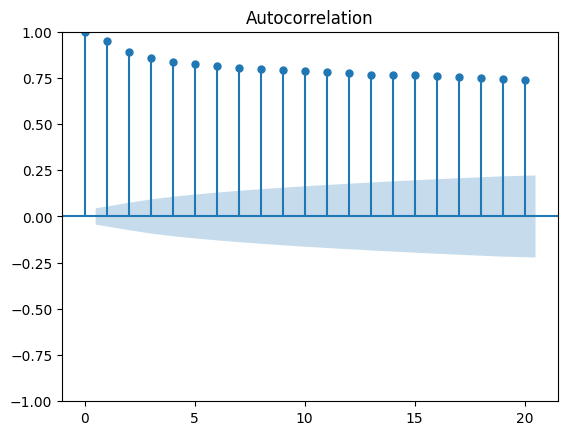

In [27]:
h = 20
plot_acf(train_data.TAVG, lags=h, adjusted=True)
plt.savefig('pictures\\acf.pdf')

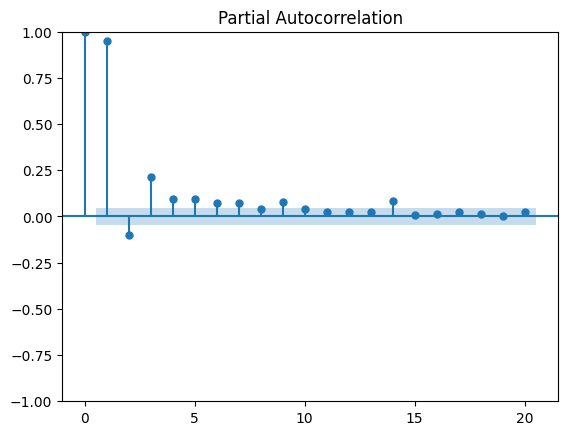

In [28]:
plot_pacf(train_data.TAVG, lags=h, method='ywm')
plt.savefig('pictures\\pacf.pdf')

To, że szereg nie jest stacjonarny w słabym sensie, potwierdzają wykresy funkcji ACF i PACF. Funkcja ACF nawet dla h=20 przyjmuje dość duże wartości. Wartość PACF dla h = 14 znajduje się poza przedziałem ufności.

### Test ADF

Niech poziom ufności $\alpha = 0.05$.\
Hipoteza zerowa $H_0$: wielomiany autoregresji mają pierwiastki jednostkowe,
Hipoteza zerowa $H_1$: wielomiany autoregresji nie mają pierwiastków jednostkowych.

In [29]:
adfuller(train_data.TAVG)

(-3.064794604961758,
 0.029270643267105795,
 13,
 1968,
 {'1%': -3.4336771595431106,
  '5%': -2.863009746829746,
  '10%': -2.5675524325901415},
 8864.012045878902)

P-wartość wynosi 0.029 < 0.05, co prowadzi do odrzucenia hipotezy zerowej. Jednak na wykresie danych wyraźnie widać okresowość danych.

# Usuwanie trendu

W danych występuje sezonowość roczna. Żeby ją usunąć zastosujemy różnicowanie z parametrem 365.

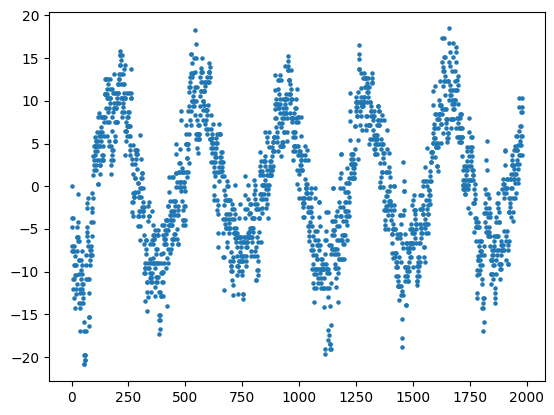

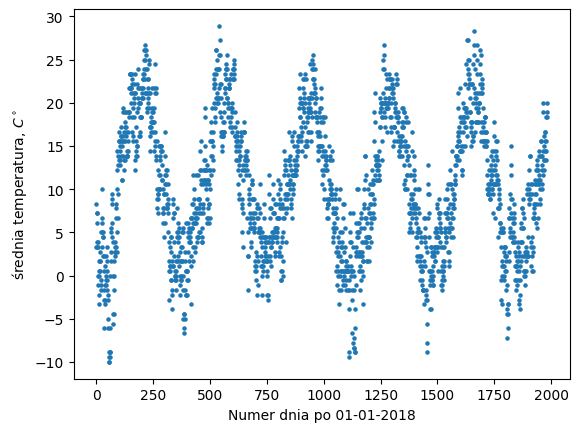

In [30]:
X = train_data.TAVG
t_list = np.arange(0,(len(train_data)),1)

a, b = np.polyfit(t_list, X, deg=1)
n = (len(train_data))
X_star = np.zeros(n)

for t in range(1,n):
    X_star[t] =  X[t] - a*t - b
    
plt.scatter(t_list,X_star, s=5)

_, ax = plt.subplots()
ax.set_ylabel('średnia temperatura, $C^\circ$')
ax.set_xlabel('Numer dnia po 01-01-2018')
ax.scatter(range(len(train_data)), train_data.TAVG, s=5)
#plt.title("Szereg czasowy Xt* (bez trendu)")
#plt.grid()

In [31]:
no_seasonality_train_temp = train_data.TAVG.diff(365)
print(no_seasonality_train_temp )

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1977   -4.444444
1978   -2.777778
1979   -1.666667
1980    1.666667
1981    1.111111
Name: TAVG, Length: 1982, dtype: float64


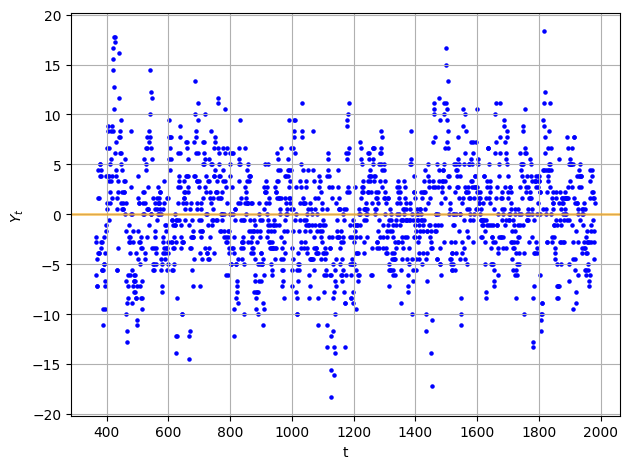

In [32]:
plt.ylabel('$Y_t$')
plt.xlabel('t')
_ = plt.scatter(range(len(no_seasonality_train_temp)), no_seasonality_train_temp, s=5, c="blue")
plt.axhline(0, c="orange", linestyle="-", alpha=0.55, linewidth=2)
plt.grid()
plt.tight_layout()
plt.savefig('pictures\\wykres_bez_sezonowosci.png')

Jak widać na powyższym wykresie, wartości $Y_t = X_t - X_{t-365}$ są losowo rozłożone wokół 0. Nie ma sezonowości, wariancja jest stała, więc otrzymany szereg czasowy prawdopodobnie jest stacjonarny w słabym sensie.

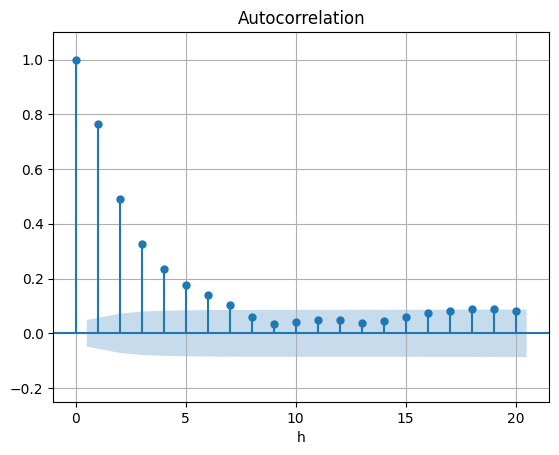

In [33]:
h = 20
plot_acf(no_seasonality_train_temp[365:], lags=h, adjusted=True)
plt.ylim([-0.25,1.1])
plt.grid()
plt.xlabel("h")
plt.savefig('pictures\\acf_bez_trendu.png')

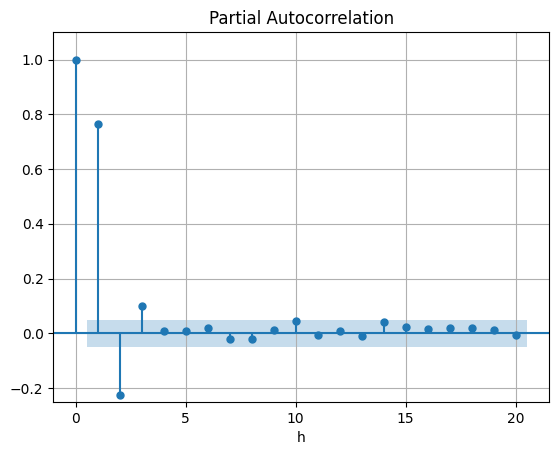

In [34]:
plot_pacf(no_seasonality_train_temp[365:], lags=h, method='ywm')
plt.ylim([-0.25,1.1])
plt.grid()
plt.xlabel("h")

plt.savefig('pictures\\pacf_bez_trendu.png')

Funkcje ACF maleje do zera wykładniczo, funkcja PACF zeruje się po h=3, co również świadczy o stacjonarności szeregu $Y_t$. Z wykresów możemy również wywnioskować, że otrzymany szereg czasowy prawdopodobnie może być opisany modelem AR(3).

In [35]:
adfuller(no_seasonality_train_temp[365:])

(-14.45519668939511,
 6.992217283344267e-27,
 2,
 1614,
 {'1%': -3.434408073569016,
  '5%': -2.863332403139172,
  '10%': -2.567724238163897},
 8164.564946552752)

Z testu ADF wynika, że szereg $Y_t$ nie posiada pierwiastków jednostkowych.

# Dobór parametrów p, q

In [36]:
data = no_seasonality_train_temp[365:]

df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 4
max_q = 4

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(data, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

In [37]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
12,3,0,8302.024779,8328.966418,8312.023793
5,1,1,8302.900572,8324.453884,8310.899784
7,1,3,8303.662856,8335.992823,8315.661673
13,3,1,8303.833881,8336.163848,8315.832698
10,2,2,8303.861992,8336.191959,8315.860809


In [38]:
model2 = pm.auto_arima(no_seasonality_train_temp[365:], 
                      d=0,
                      start_p=0, start_q=0, max_d=0, 
                      max_p=4, max_q=4, max_order=6,
                      trace=True, seasonal=False,
                      #suppress_warnings=True, 
                      stepwise=False
                      )

# print model summary
print(model2.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9805.653, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8734.410, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8423.245, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=8355.832, Time=0.14 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=8325.392, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8395.794, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8300.939, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8302.935, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8301.698, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=8303.625, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8313.944, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8302.936, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8301.894, Time=0.37 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8303.581, Time=0.38 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=8305.612, Time=0.27 sec
 ARIMA(3,0

In [39]:
p, q = 3, 0

Kryterium AIC ma najmniejszą wartość dla rzędów p=3, q=0.

# Dobór parametrów modelu

In [40]:
model = ARIMA(no_seasonality_train_temp[365:], order=(p, 0, q)).fit()
print(model)

In [41]:
residuals = model.resid
parameters = model.params
print(parameters)


const    -0.052672
ar.L1     0.956735
ar.L2    -0.317180
ar.L3     0.098868
sigma2    9.869775
dtype: float64


# Weryfikacja założeń dotyczących szumu

### Średnia

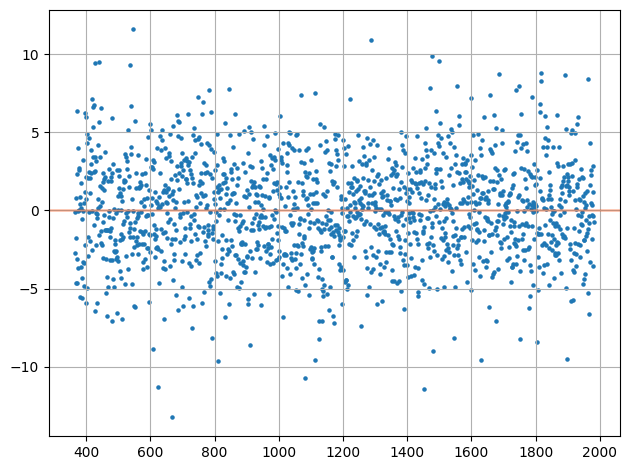

In [42]:
plt.scatter(range(365, 365 + len(residuals)), residuals, s=5)
plt.grid()
plt.axhline(0, c="orangered", alpha=0.3, linewidth=2)
plt.tight_layout()
plt.savefig('pictures\\szum.png')

Residua losowo układają się wokół zera, wariancja jest stała.

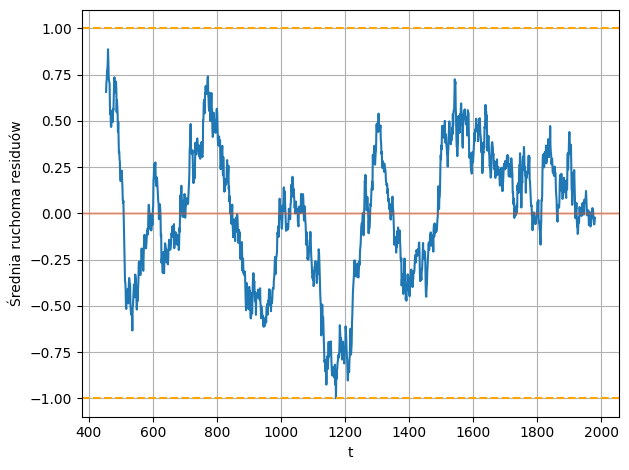

In [43]:
plt.xlabel('t')
plt.ylabel('Średnia ruchoma residuów')
residuals.rolling(window=90).mean().plot()
plt.axhline(1, linestyle="--", color="orange")
plt.axhline(-1, linestyle="--", color="orange")
plt.axhline(0, c="orangered", alpha=0.3, linewidth=2)
plt.grid()
plt.tight_layout()
plt.savefig('pictures\\srednia_ruchoma.png')

Średnia jest bliska 0 dla wszystkich t, zmienia się w przedziale [-1, 1], nie widać trendu ani okresowości.

### Wariancja

Modified Levene test.
Hipoteza zerowa $H_0:$ dane pochodzą z rozkładów o takiej samej wariancji.
Niech poziom ufności $\alpha = 0.05$.

W danych pogoodowych niestała wariancja residuów mogłaby wynikać z tego, że wariancja temperatur jest różna w różnych sezonach. Dlatego dzielimy wektor residuów na 15 części, każda z których będzie zawierała jeden sezon.

In [44]:
arrays = np.split(residuals[365:-7], 15)
#print(arrays)
print(stats.levene(*arrays))

LeveneResult(statistic=1.5376843772585298, pvalue=0.09075573258852325)


P-wartość wynosi 0.09 > 0.05, więc przyjmujemy hipotezę zerową. Residua mają stałą wariancję.

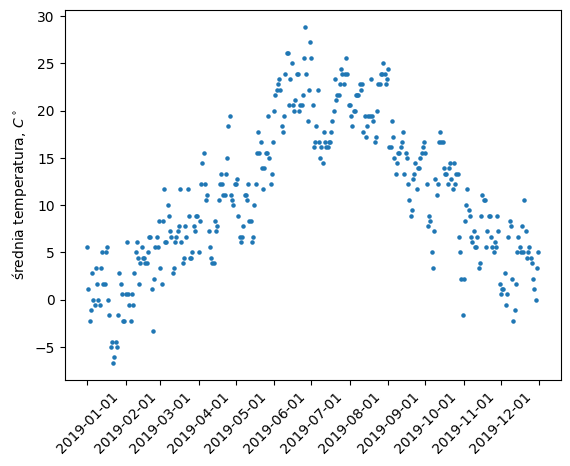

In [45]:
_, ax = plt.subplots()
ax.set_ylabel('średnia temperatura, $C^\circ$')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', rotation=45)
ax.scatter(weather_data.DATE[365:2*365], weather_data.TAVG[365:2*365], s=5)
plt.savefig('wykres_danych.pdf')

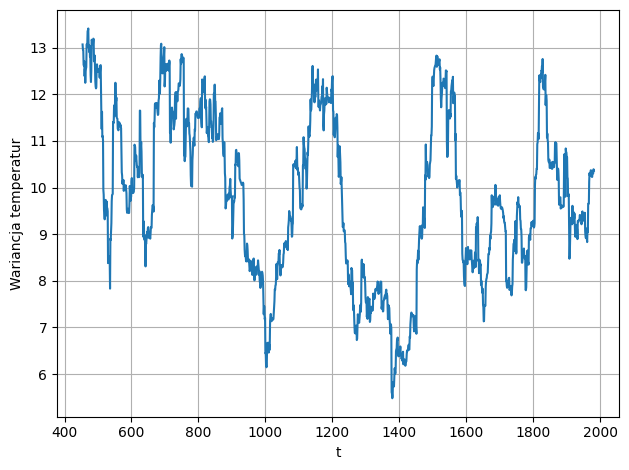

In [48]:
plt.ylabel('Wariancja temperatur')
plt.xlabel("t")
_ = residuals.rolling(window=90).var().plot()
plt.grid()
plt.tight_layout()
plt.savefig("pictures//war_90.png")

Odchylenie standardowe oscyluje wokół 9 i zmienia się w przedziale [5; 15]?, co nie jest dużą zmianą w przypadku temperatur. Na wykresie nie widać również okresowości.

### Niezależność

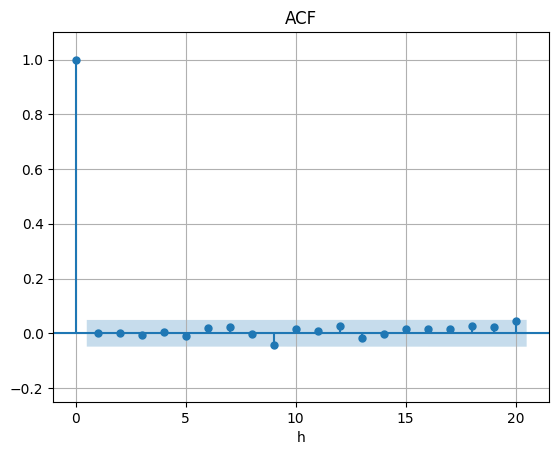

In [123]:
plot_acf(residuals, lags=20)
plt.ylim([-0.25,1.1])
plt.xlabel('h')
plt.grid()
plt.title("ACF")

plt.savefig('pictures\\acf_residua.png')

C:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


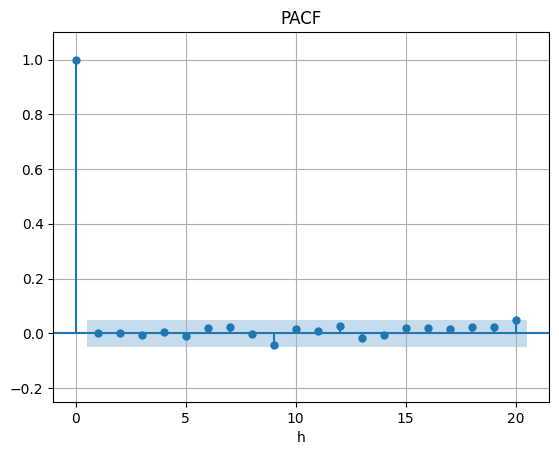

In [124]:
plot_pacf(residuals, lags=20)
plt.ylim([-0.25,1.1])
plt.xlabel('h')
plt.grid()
plt.title("PACF")
plt.savefig('pictures\\pacf_residua.png')

Z wykresów ACF i PACF wynika, że residua są nieskorelowane.

### Rozkład residuów

In [125]:
stats.kstest(residuals , cdf='norm')

KstestResult(statistic=0.2498351097280527, pvalue=2.0674605927565478e-89)

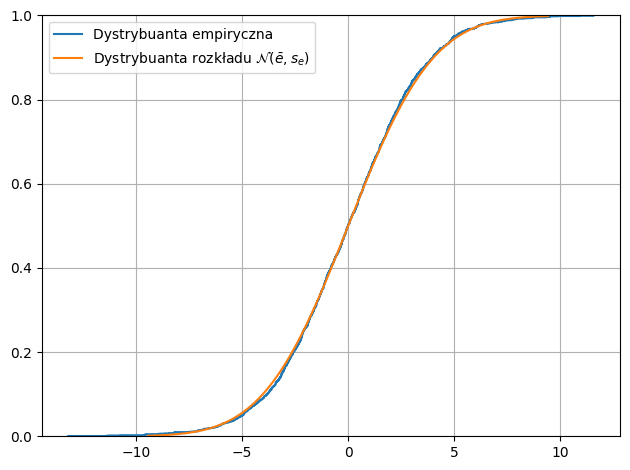

In [126]:
sns.ecdfplot(residuals)
t = np.linspace(np.mean(residuals) - 3 * np.std(residuals), np.mean(residuals) + 3 * np.std(residuals), 100)
plt.plot(t, stats.norm.cdf(t, np.mean(residuals), np.std(residuals)), c='C1')
plt.grid()
plt.ylabel("")
plt.tight_layout()
_ = plt.legend(['Dystrybuanta empiryczna', 'Dystrybuanta rozkładu $\mathcal{N}(\\bar{e}, s_{e})$'])
plt.savefig("pictures//dystrybuanty.png")

Z wykresu dystrybuant i testu Kołmogorowa-Smirnowa wnioskujemy, że residua mają rozkład normalny.

# Ocena dopasowania modelu

### Przedziały ufności dla ACF

In [127]:
n = 1000
N = 1000
h_range = 20

In [128]:

ar_models = [arma_generate_sample(ar=[1] + list(-parameters[1: -1]), ma=[1], nsample=n, scale=np.std(residuals)) for _ in range(N)]


In [129]:
correlation_matrix = np.array([tools.acf(m, nlags=h) for m in ar_models])

In [130]:
alpha = 0.05
quantiles_lower = np.quantile(correlation_matrix, alpha/2, axis=0)
quantiles_upper = np.quantile(correlation_matrix, 1 - alpha/2, axis=0)

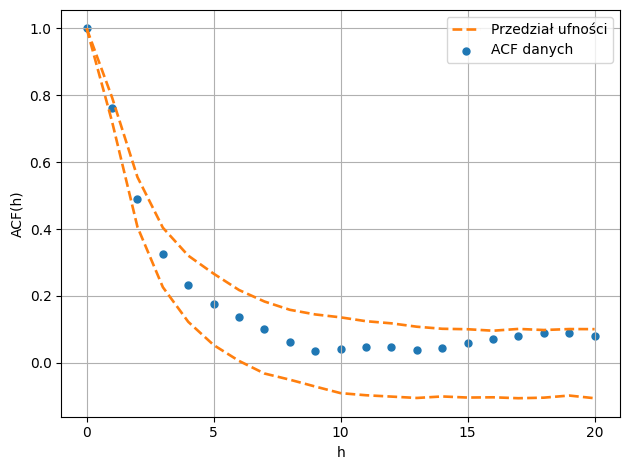

In [131]:
line1, = plt.plot(range(h+1), quantiles_lower, linestyle="dashed", color="C1",linewidth=1.9)
plt.plot(range(h+1), quantiles_upper,  linestyle="dashed", color="C1",linewidth=1.9)
line2 = plt.scatter(range(h+1), tools.acf(no_seasonality_train_temp[365:], nlags=h), s=25)
plt.xlabel('h')
plt.ylabel('ACF(h)')
plt.legend([line1, line2], ['Przedział ufności', 'ACF danych'])
plt.xticks(ticks=range(0, 21, 5))
plt.grid()
plt.tight_layout()
plt.savefig('pictures\\ACF_przedzialy_ufnosci.png')

Wszyskie wartości funkcji ACF dla danych znajdują się w swoich przedziałach ufności, jednocześnie przedziały nie są zbyt szerokie.

### Przedziały ufności dla PACF

In [132]:
ar_models = [arma_generate_sample(ar=[1] + list(-parameters[1: -1]), ma=[1], nsample=n, scale=np.std(residuals)) for _ in range(N)]

In [133]:
partial_correlation_matrix = np.array([tools.pacf(m, nlags=h) for m in ar_models])

In [134]:
alpha = 0.05
quantiles_lower = np.quantile(partial_correlation_matrix, alpha/2, axis=0)
quantiles_upper = np.quantile(partial_correlation_matrix, 1 - alpha/2, axis=0)

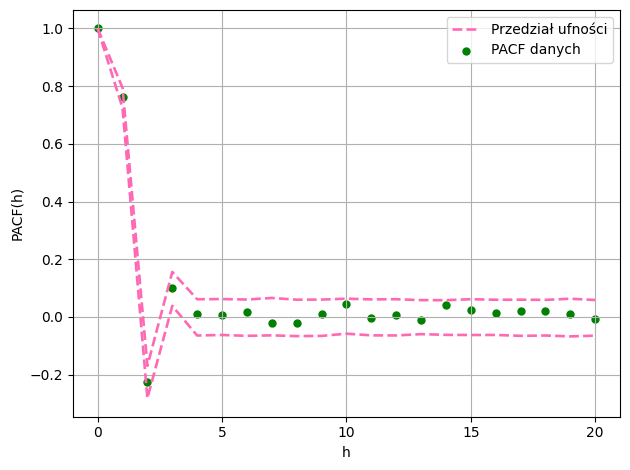

In [135]:
line1, = plt.plot(range(h+1), quantiles_lower, c='hotpink', linestyle="dashed", linewidth=1.9)
plt.plot(range(h+1), quantiles_upper,linestyle="dashed", color="hotpink",linewidth=1.9)
line2 = plt.scatter(range(h+1), tools.pacf(no_seasonality_train_temp[365:], nlags=h), color="g", s=25)
plt.xlabel('h')
plt.ylabel('PACF(h)')
plt.grid()
plt.tight_layout()
plt.legend([line1, line2], ['Przedział ufności', 'PACF danych'])
plt.xticks(ticks=range(0, 21, 5))
plt.savefig('pictures\\PACF_przedzialy_ufnosci.png')

### Wykres kawantylowy

In [136]:
N = 10000
n = len(train_data[365:])
print(n)

1617


In [137]:
ar_models = [arma_generate_sample(ar=[1] + list(-parameters[1: -1]), ma=[1], nsample=n, scale=np.std(residuals)) for _ in range(N)]
ar_seasonal_models = [ar_model + train_data.TAVG[:-365] for ar_model in ar_models]

In [138]:
quantiles_lower = np.quantile(ar_seasonal_models, alpha/2, axis=0)
quantiles_upper = np.quantile(ar_seasonal_models, 1 - alpha/2, axis=0)

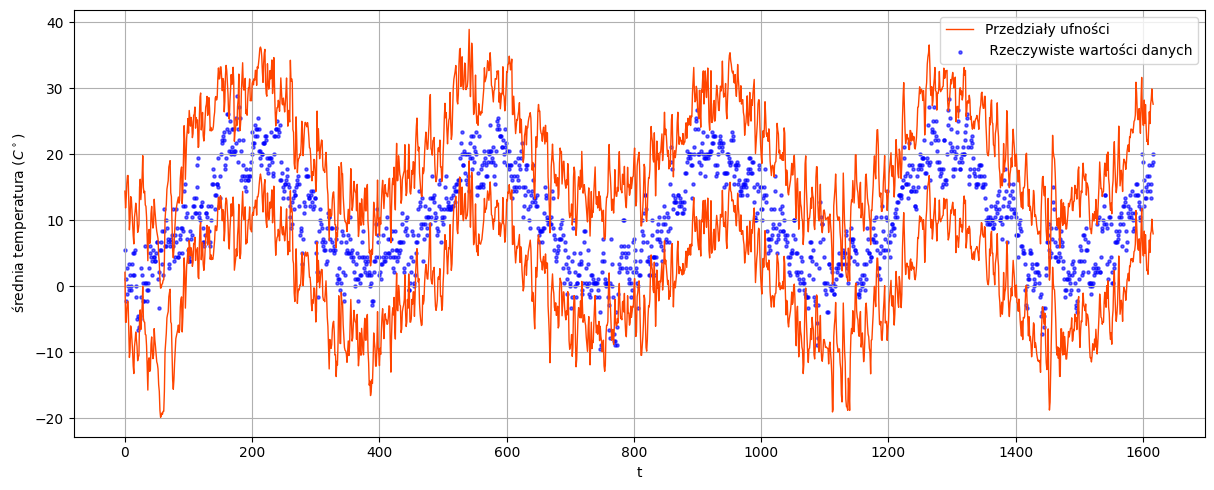

In [139]:
plt.figure(figsize=(12, 5))
line1, = plt.plot(range(n), quantiles_lower, c='orangered', linewidth=1)
line2, = plt.plot(range(n), quantiles_upper, c='orangered', linewidth=1)
line3 = plt.scatter(range(n), train_data.TAVG[365:], s=5, c='blue', alpha=0.6)
plt.legend([line1, line3], ['Przedziały ufności', ' Rzeczywiste wartości danych'])
plt.xlabel('t')
plt.grid()
plt.tight_layout()
plt.ylabel('średnia temperatura ($C^\circ$)')
plt.savefig('pictures\\wykres_kwantylowy.png')

In [140]:
train_temperatures = train_data[365:].reset_index().TAVG
counter = 0
for i in range(n):
    if quantiles_lower[i] <= train_temperatures[i] <= quantiles_upper[i]:
        counter += 1
print(counter/n)

0.9443413729128015


In [141]:
np.mean(quantiles_upper - quantiles_lower)

19.630459779029383

### Prognoza przyszłych wartości

In [164]:
n = len(test_data)
N = 10000

In [165]:
parameters = model.params

In [166]:
ar_models = [arma_generate_sample(ar=[1] + list(-parameters[1: -1]), ma=[1], nsample=n, scale=np.std(residuals)) for _ in range(N)]

In [167]:
ar_seasonal_models = [ar_model + train_data.TAVG[-365:-365+n] for ar_model in ar_models]

In [168]:
quantiles_lower = np.quantile(ar_seasonal_models, alpha/2, axis=0)
quantiles_upper = np.quantile(ar_seasonal_models, 1 - alpha/2, axis=0)

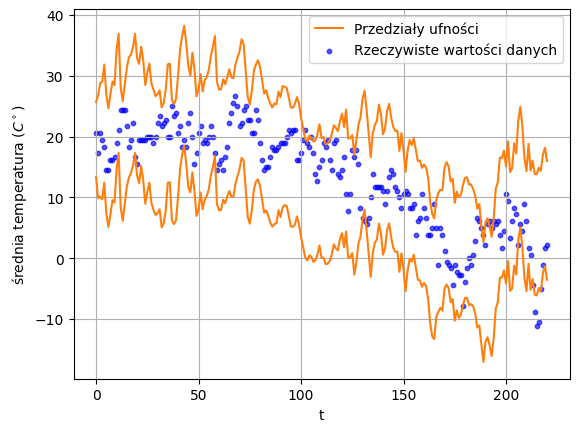

In [169]:
line1, = plt.plot(range(n), quantiles_lower, c='C1')
line2, = plt.plot(range(n), quantiles_upper, c='C1')
line3 = plt.scatter(range(n), test_data.TAVG, s=10, c='blue', alpha=0.65)
plt.legend([line1, line3], ['Przedziały ufności', 'Rzeczywiste wartości danych'])
plt.xlabel('t')
plt.ylabel('średnia temperatura ($C^\circ$)')
plt.grid()
plt.savefig('pictures\\prognoza1.png')

Większość rzeczywistych temperatur ze zbioru testowego wpada do swoich przedziałów ufności, więc model jest dobrze dopasowany.

In [170]:
test_temperatures = test_data.reset_index().TAVG
counter = 0
for i in range(n):
    if quantiles_lower[i] <= test_temperatures[i] <= quantiles_upper[i]:
        counter += 1
print(counter/n)

0.9321266968325792


In [171]:
np.mean(quantiles_upper - quantiles_lower)

19.601932623170804

### Dla arma(1; 1)

In [172]:
model11 = ARIMA(no_seasonality_train_temp[365:], order=(1, 0, 1)).fit()

In [173]:
parameters11 = model11.params
residuals11 = model11.resid
ar_parameters11 = parameters11[1]
ma_parameters11 = parameters11[2]

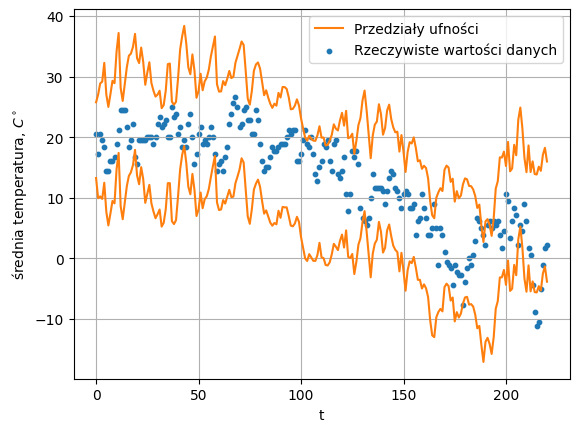

In [174]:
n = len(test_data)
N = 10000
ar_models = [arma_generate_sample(ar=[1, -ar_parameters11], ma=[1, ma_parameters11], nsample=n, scale=np.std(residuals11)) for _ in range(N)]
ar_seasonal_models = [ar_model + train_data.TAVG[-365:-365 + n] for ar_model in ar_models]
quantiles_lower = np.quantile(ar_seasonal_models, alpha/2, axis=0)
quantiles_upper = np.quantile(ar_seasonal_models, 1 - alpha / 2, axis=0)
line1, = plt.plot(range(n), quantiles_lower, c='C1')
line2, = plt.plot(range(n), quantiles_upper, c='C1')
line3 = plt.scatter(range(n), test_data.TAVG, s=10, c='C0')
plt.legend([line1, line3], ['Przedziały ufności', 'Rzeczywiste wartości danych'])
plt.xlabel('t')
plt.ylabel('średnia temperatura, $C^\circ$')
plt.grid()
plt.savefig('pictures\\prognoza2.png')

In [175]:
np.mean(quantiles_upper - quantiles_lower)

19.616432688817465

In [159]:
counter = 0
for i in range(n):
    if quantiles_lower[i] <= test_temperatures[i] <= quantiles_upper[i]:
        counter += 1
print(counter/n)

0.9321266968325792
